In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Import Library

In [ ]:
import os
import torch
import numpy as np
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image
from glob import glob
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn as nn
import torch.nn.functional as F
import torchvision

## Dataset Frog

In [ ]:
# Custom Dataset
class CustomFrogDataset(Dataset):
    def __init__(self, file_paths, transform=None):
        self.file_paths = file_paths
        self.transform = transform

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        file_path = self.file_paths[idx]
        label = os.path.basename(file_path).split('_')[0]
        label_dict = label_dict = {
            'Boana': 0,
            'Pool': 1,
            'PepperFrog': 2,
            'South': 3,
            'Dendropsophus': 4,
            'Leptodactylus': 5,
            'Rana': 6,
            'Rhinella': 7,
            'Scinax': 8
        }
        label = label_dict[label]

        # Load MFCC
        image = np.load(file_path)
        image = Image.fromarray(image)

        if self.transform:
            image = self.transform(image)

        return image, label

transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),  # Konversi ke grayscale
    transforms.Resize((224, 224)),               # Resize gambar ke 224x224
    transforms.RandomAffine(degrees=10, shear=20),  # Affine transform
    transforms.ToTensor(),                      # Konversi ke tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

## Load Data

In [ ]:
# Path file
train_files = glob('/content/drive/MyDrive/TUBES DL/Persiapan Data/Dataset/Test_Train_Val/train/*.npy')
val_files = glob('/content/drive/MyDrive/TUBES DL/Persiapan Data/Dataset/Test_Train_Val/val/*.npy')
test_files = glob('/content/drive/MyDrive/TUBES DL/Persiapan Data/Dataset/Test_Train_Val/test/*.npy')

# Dataset dan DataLoader dengan augmentasi untuk train dataset
train_dataset = CustomFrogDataset(train_files, transform=transform)
val_dataset = CustomFrogDataset(val_files, transform=transform)
test_dataset = CustomFrogDataset(test_files, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
print(f"Jumlah file train: {len(train_files)}")
print(f"Jumlah file val: {len(val_files)}")
print(f"Jumlah file test: {len(test_files)}")

Jumlah file train: 666
Jumlah file val: 81
Jumlah file test: 90


## Model Dense Net 121 (Modified Dense Net 121)

In [ ]:
class ModifiedDenseNet121(nn.Module):
    def __init__(self, num_classes, dropout_prob=0.5):
        super(ModifiedDenseNet121, self).__init__()
        self.densenet121 = torchvision.models.densenet121(pretrained=True)
        self.features = self.densenet121.features
        self.batch_norm1 = nn.BatchNorm2d(1024)  # Batch normalization setelah feature extraction
        self.dropout1 = nn.Dropout(p=dropout_prob)  # Dropout tambahan setelah batch normalization
        self.dropout2 = nn.Dropout(p=dropout_prob)  # Dropout tambahan sebelum classifier
        self.classifier = nn.Linear(self.densenet121.classifier.in_features, num_classes)

    def forward(self, x):
        # Feature extraction
        x = self.features(x)
        # Batch normalization setelah feature extraction
        x = self.batch_norm1(x)
        # Aktivasikan ReLU
        x = F.relu(x, inplace=True)
        # Menambahkan adaptive pooling dan flatten
        x = F.adaptive_avg_pool2d(x, (1, 1)).view(x.size(0), -1)  # Flatten features
        # Dropout tambahan
        x = self.dropout1(x)  # Apply first Dropout
        # Classifier layer
        x = self.classifier(x)
        # Dropout sebelum klasifikasi akhir
        x = self.dropout2(x)  # Apply second Dropout

        return x

# Initialize model, criterion, optimizer, scheduler
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ModifiedDenseNet121(num_classes=9).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=3, verbose=True)

# Training loop
epochs = 30
train_acc_history = []
val_acc_history = []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct_preds = 0
    total_preds = 0

    # Training loop
    for data in train_loader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        correct_preds += (predicted == labels).sum().item()
        total_preds += labels.size(0)

    train_accuracy = 100 * correct_preds / total_preds
    train_acc_history.append(train_accuracy)
    print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {running_loss/len(train_loader):.4f}, Train Acc: {train_accuracy:.2f}%')

    # Validation loop
    model.eval()
    correct_preds = 0
    total_preds = 0
    val_loss = 0.0

    with torch.no_grad():
        for data in val_loader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            correct_preds += (predicted == labels).sum().item()
            total_preds += labels.size(0)

    val_accuracy = 100 * correct_preds / total_preds
    val_acc_history.append(val_accuracy)
    print(f'Val Loss: {val_loss/len(val_loader):.4f}, Val Acc: {val_accuracy:.2f}%')

    # Update scheduler
    scheduler.step(val_loss / len(val_loader))

# Test phase
model.eval()
correct_preds = 0
total_preds = 0
test_loss = 0.0

with torch.no_grad():
    for data in test_loader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        correct_preds += (predicted == labels).sum().item()
        total_preds += labels.size(0)

test_accuracy = 100 * correct_preds / total_preds
print(f'Test Loss: {test_loss/len(test_loader):.4f}, Test Acc: {test_accuracy:.2f}%')

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 182MB/s]
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  wa

Epoch [1/30], Train Loss: 2.2183, Train Acc: 13.96%
Val Loss: 2.1529, Val Acc: 19.75%
Epoch [2/30], Train Loss: 2.0873, Train Acc: 21.32%
Val Loss: 2.0769, Val Acc: 23.46%
Epoch [3/30], Train Loss: 1.9632, Train Acc: 25.68%
Val Loss: 1.9400, Val Acc: 40.74%
Epoch [4/30], Train Loss: 1.8785, Train Acc: 30.18%
Val Loss: 1.9010, Val Acc: 39.51%
Epoch [5/30], Train Loss: 1.7703, Train Acc: 34.53%
Val Loss: 1.6652, Val Acc: 55.56%
Epoch [6/30], Train Loss: 1.6843, Train Acc: 36.79%
Val Loss: 1.6317, Val Acc: 51.85%
Epoch [7/30], Train Loss: 1.6194, Train Acc: 38.14%
Val Loss: 1.6094, Val Acc: 49.38%
Epoch [8/30], Train Loss: 1.5875, Train Acc: 40.84%
Val Loss: 1.4513, Val Acc: 58.02%
Epoch [9/30], Train Loss: 1.5642, Train Acc: 39.34%
Val Loss: 1.3934, Val Acc: 62.96%
Epoch [10/30], Train Loss: 1.5002, Train Acc: 41.59%
Val Loss: 1.3680, Val Acc: 58.02%
Epoch [11/30], Train Loss: 1.4453, Train Acc: 43.69%
Val Loss: 1.4471, Val Acc: 49.38%
Epoch [12/30], Train Loss: 1.4368, Train Acc: 42.49%

## Plot Training and Validation Accuracy

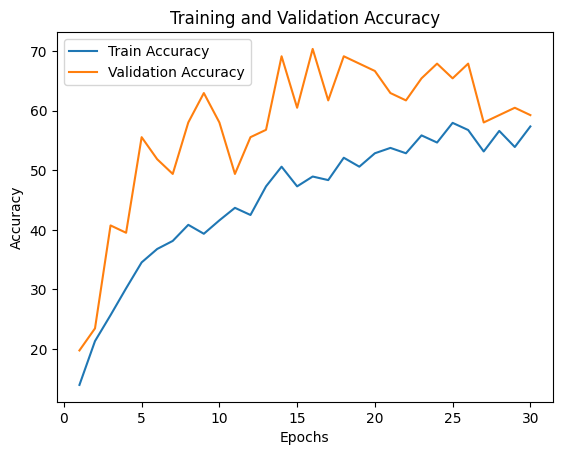

In [ ]:
plt.plot(range(1, epochs + 1), train_acc_history, label="Train Accuracy")
plt.plot(range(1, epochs + 1), val_acc_history, label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Training and Validation Accuracy")
plt.show()

## Evaluation Metrics

In [ ]:
# Test Evaluation
model.eval()
all_labels = []
all_predictions = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

# Metrics
accuracy = accuracy_score(all_labels, all_predictions)
precision = precision_score(all_labels, all_predictions, average='weighted')
recall = recall_score(all_labels, all_predictions, average='weighted')
f1 = f1_score(all_labels, all_predictions, average='weighted')

print(f"Akurasi: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

Akurasi: 0.68
Precision: 0.71
Recall: 0.68
F1 Score: 0.68


## Confussion Matrix

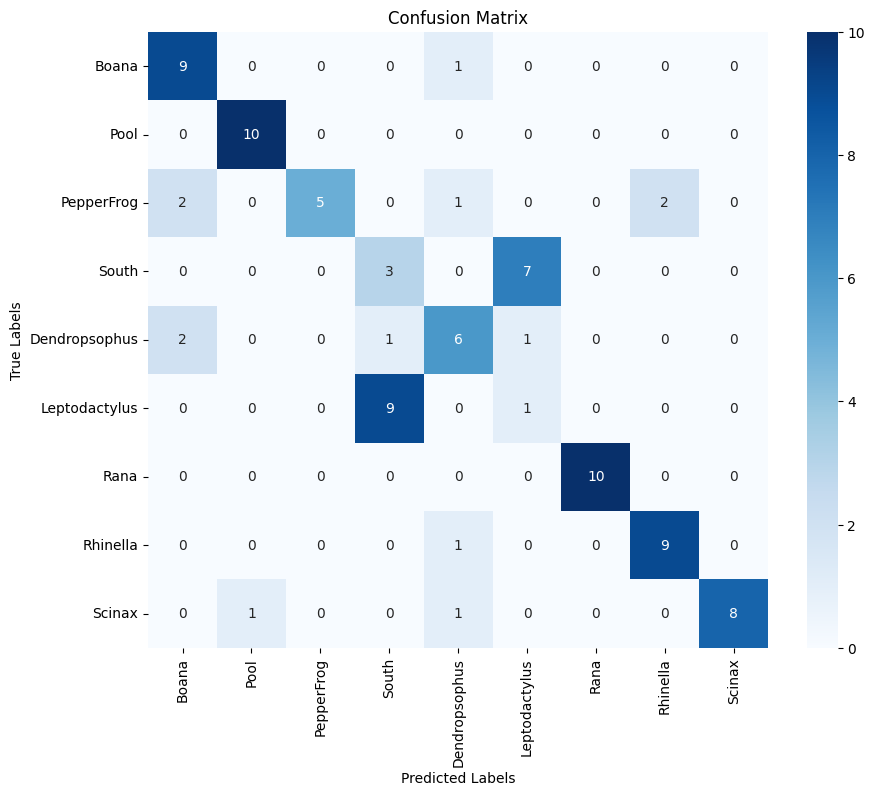

In [ ]:
class_labels = [
    'Boana',
    'Pool',
    'PepperFrog',
    'South',
    'Dendropsophus',
    'Leptodactylus',
    'Rana',
    'Rhinella',
    'Scinax'
]

# Hitung confusion matrix
cm = confusion_matrix(all_labels, all_predictions)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


## Menyimpan model ke drive

In [ ]:
model = ModifiedDenseNet121(num_classes=9)
model_save_path = '/content/drive/MyDrive/TUBES DL/Model Transfer Learning/model_densenet121_frog_classifier.pth'
torch.save(model.state_dict(), model_save_path)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
